![Title](cisco.png)

# Lab - Internet Meter Anomaly Detection 

## Part 1 : Feature Engineering

#### Step 1: Import Python Libraries.

In [37]:
import numpy as np
import pandas as pd

#### Step 2: Create a Dataframe and modify the quantities.
“ping” no es la opción ideal para el análisis estadístico. Para mejores
resultados, puede utilizar una función relacionada, que llamaremos "velocidad de ping". Esto se calcula
aplicando una transformación simple:$$\mathrm{ping\ rate} = \frac{1}{\mathrm{ping\ time}}.$$
Este proceso de "modificar" cantidades para el análisis se denomina "ingeniería de funciones" y es, por lo
general, una parte importantes del flujo de trabajo del aprendizaje automático.

In [38]:
# Load internet speed data
df = pd.read_csv('./rpi_data_processed.csv')
df.head()

Date      Time  Ping (ms)  Download (Mbit/s)  Upload (Mbit/s)
0  2016-11-24  13:36:25     26.992              91.80            14.31
1  2016-11-24  13:36:55     24.532              88.19            14.12
2  2016-11-24  13:37:25     20.225              59.86            14.11
3  2016-11-24  13:37:57     19.332              91.81            14.22
4  2016-11-24  13:38:27     22.494              92.05            14.08

In [39]:
# Initialize dataframe df_rates
df_rates = df.drop(['Ping (ms)', 'Date', 'Time'], axis=1)

# Rename the download and upload columns of df_rates
lookup = {'Download (Mbit/s)': 'download_rate', 
          'Upload (Mbit/s)': 'upload_rate'}
df_rates = df_rates.rename(columns = lookup)

# Calculate ping_rate
ping_rate = 1. / df['Ping (ms)']

# Convert ping_rate to 1/seconds
ping_rate = 1000. * ping_rate

# Add a column to complete the task
df_rates['ping_rate'] = ping_rate

In [40]:
# Inspect the result
df_rates.head()

download_rate  upload_rate  ping_rate
0          91.80        14.31  37.048014
1          88.19        14.12  40.763085
2          59.86        14.11  49.443758
3          91.81        14.22  51.727705
4          92.05        14.08  44.456299

#### Step 3:  Visualize the Data.
**Optional** <br>
* La clase `Axes3D` de `mpl_toolkits.mplot3d` le permite generar gráficos tridimensionales y extender las funcionalidades del módulo familiar `matplotlib.pyplot`. 
* El método `interact`, que juega un papel esencial en la animación de las visualizaciones, se obtiene desde `ipywidgets`. Este módulo, a su vez, es parte del entorno de `Ipython` para ejecutar Python de forma interactiva.

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

In [42]:
def scatter_view(x, y, z, azim, elev):
    # Init figure and axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    # Compute scatter plot
    ax.scatter(x, y, z)
    ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
    ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
    ax.set_zlabel('P rate (1/s)', fontsize=16)
    
    # Specify azimuth
    # and elevation
    ax.azim = azim
    ax.elev = elev

In [43]:
# Draw interactive plot
xi = df_rates['download_rate']
yi = df_rates['upload_rate']
zi = df_rates['ping_rate']
interact(lambda azim, elev: scatter_view(xi, yi, zi, azim, elev),
         azim=(0, 90), elev=(0, 90))
plt.show()

interactive(children=(IntSlider(value=45, description='azim', max=90), IntSlider(value=45, description='elev',…

## Part 2: Euclidean Anomaly Detection

Las anomalías se ubican lejos del "punto promedio". Los puntos que se encuentran más allá de cierta distancia del promedio se considerarán anómalos, mientras que el resto se considerará normal.

Representemos las coordinadas `[download_rate, upload_rate, ping_rate]` de un punto de datos  $\{x, y, z\}$. Luego, la distancia de una medición desde la ubicación promedio $\{\mu_{x}, \mu_{y}, \mu_{z}\}$ es el resultado de la fórmula:

$$d = \sqrt{(x - \mu_x)^2 + (y-\mu_y)^2 + (z - \mu_z)^2},$$ 

Este concepto común de distancia se denomina **Euclidean** para distinguirlo de posibles generalizaciones. 

#### Step 1: Calculate the means.

In [85]:
mu = df_rates.mean()
mu

download_rate    90.449212
upload_rate      13.697608
ping_rate        48.657348
dtype: float64

#### Step 2: Calculate the Euclidean distance.
Busque la distancia euclidiana entre cada punto y la ubicación promedio. Puede recurrir a las funciones
Numpy `np.square` y `np.sqrt`. Estas computan la potencia cuadrada y la raíz cuadrada [basadas en elementos]
de cualquier matriz de entrada, lo que facilita el cálculo de distancias sin bucles `for` que se iteran entre los puntos de datos.

In [86]:
euclid_sq = np.square(df_rates - mu).sum(axis=1)
euclid = np.sqrt(euclid_sq)

#### Step 3: Create a histogram.
Las anomalías se reconocen en la "cola" del histograma 

Text(0, 0.5, 'Relative frequency')

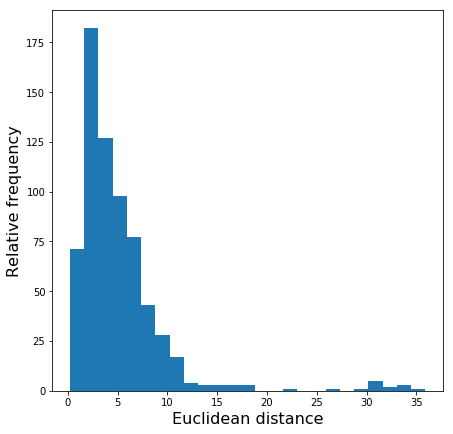

In [87]:
# Histogram of Euclidean distance
fig = plt.figure(figsize=(7, 7))
# plot the histogram using 25 bins
plt.hist(euclid, bins=25)

plt.xlabel('Euclidean distance', fontsize=16)
plt.ylabel('Relative frequency', fontsize=16)

#### Step 4: Compute the normalized distance.
La **distancia normalizada** es la relación de cada distancia sobre el valor máximo de d. Los puntos anómalos más alejados tienen, entonces, una distancia normalizada de 1.

In [92]:
# Maximum Euclidean distance
max_euclid = euclid.max()
max_euclid

35.88517639980918

In [93]:
# Normalized Euclidean distance
nmd_euclid = (df_rates - nmd_euclid)

#### Step 5: Visualize the alarm rate.
Para etiquetar puntos como normales o anómalos, debe definir un **límite de decisión**. Es necesario
seleccionar la distancia más allá de qué puntos se consideran anormales. Si bien la posición del límite se
puede fijar según consideraciones cualitativas, es preferible un enfoque cuantitativo. Puede aumentar
gradualmente la distancia de decisión y monitorear cómo varía el índice de alarma. Específicamente, el
índice de alarma es la cantidad de anomalías dividida por la cantidad total de puntos de datos. Este
procedimiento prueba todos los límites de decisiones posibles y nos permite seleccionar el más adecuado.

In [98]:
# Modifique la distancia de decisión normalizada de 0 a 1 y registre el índice de alarmas en cada paso.
ecl_alarm_rate = [] #indice de alarma
nmd_range = np.linspace(0, 1, 400) #distancia normalizada
for nmd_decision in nmd_range:  
    ecl_alarm_rate.append(nmd_decision)

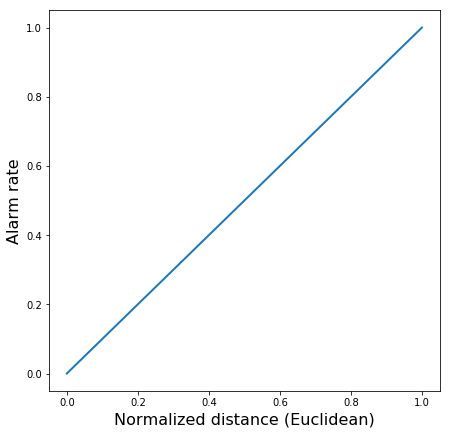

In [99]:
# Plot number of alarms as a function of decision distance
fig = plt.figure(figsize=(7, 7))
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)
plt.show()

#### Step 6: Select the decision boundary.
El gráfico de arriba convierte el problema de fijar un límite de decisión en el de seleccionar el índice de
alarmas. Esto es una ventaja porque el dominio de aplicación, por lo general, determina una elección
razonable para el índice de alarmas.

In [101]:
# Elegimos índice de alarmas ideal= 0.1
threshold = 0.1
#ecl_theshold guarda el indice exacto
index, ecl_threshold = next(tpl for tpl in enumerate(ecl_alarm_rate) if tpl[1] < threshold)
#Distancia de decisión normalizada más pequeña, el índice caiga por debajo del umbral.
ecl_decision = nmd_range[index]

#### Step 7: Visualize the decision boundary.

Text(0, 0.5, 'Alarm rate')

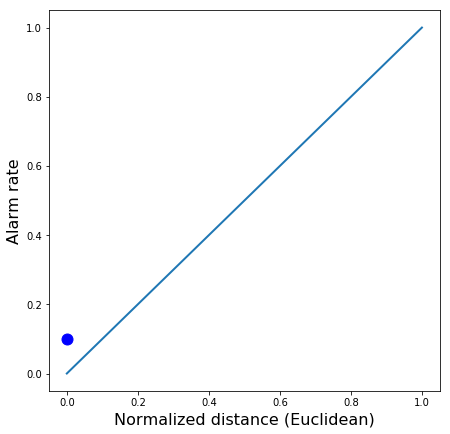

In [105]:
# Alarm rate with decision boundary
fig = plt.figure(figsize=(7, 7))
# Plot the alarm rate as a function of the normalized euclidean distance
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
# Plot the chosen decision threshold and the curresponding alarm rate
plt.plot(ecl_decision,threshold,'bo', markersize=11)

plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)

#### Step 8: Visualize the decision boundary in 3D.
Debido a que nuestro algoritmo de detección de anomalías utiliza distancias auclidianas, sus límites de decisión, cuando se viaualizan en tres dimensiones, son esféricos. 

In [106]:
# Decision sphere (Polar coordinates)
radius = ecl_decision * max_euclid
phi = np.linspace(0, 2 * np.pi, 300)
theta = np.linspace(0, 2 * np.pi, 300)

# Decision sphere (Cartesian coordinates)
xs = radius * np.outer(np.sin(theta), np.cos(phi))
ys = radius * np.outer(np.sin(theta), np.sin(phi))
zs = radius * np.outer(np.cos(theta), np.ones(np.size(phi)))

# Center decision sphere at mean
ecl_xd = xs + df_rates['download_rate'].mean()
ecl_yd = ys + df_rates['upload_rate'].mean()
ecl_zd = zs + df_rates['ping_rate'].mean()

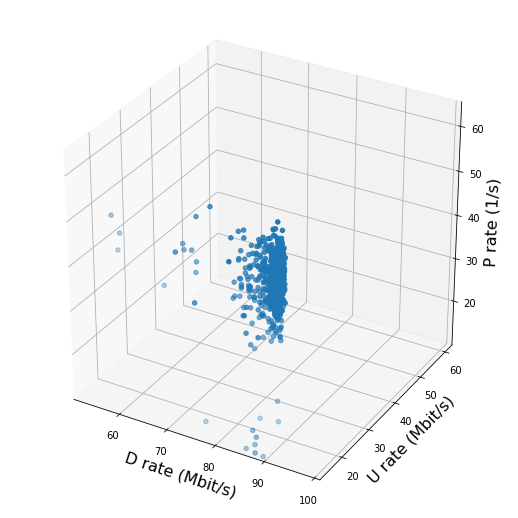

In [107]:
# Init figure and axes
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig)

# Plot data
ax.scatter(df_rates['download_rate'],
           df_rates['upload_rate'], 
           df_rates['ping_rate'])

# Plot decision boundary
ax.plot_surface(ecl_xd, ecl_yd, ecl_zd,
                linewidth=0, alpha=0.25)

# Label axes
ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
ax.set_zlabel('P rate (1/s)', fontsize=16)
    
# --------------------------------------------------
# Set equal aspect ratio for all axes
# --------------------------------------------------

# Extreme values of x, y, z
extremes = []
extremes.append([df_rates['download_rate'].min(),
                 df_rates['download_rate'].max()])
extremes.append([df_rates['upload_rate'].min(),
                 df_rates['upload_rate'].max()])
extremes.append([df_rates['ping_rate'].min(),
                 df_rates['ping_rate'].max()])

# Half-widths and mid-points
hwidths = [(row[1] - row[0]) / 2.0 for row in extremes]
midpts = [(row[1] + row[0]) / 2.0 for row in extremes]

# Set xlim, ylim, zlim
left_ends = midpts - np.max(hwidths)
right_ends = midpts + np.max(hwidths)
ax.set_xlim([left_ends[0], right_ends[0]]);
ax.set_ylim([left_ends[1], right_ends[1]]);
ax.set_ylim([left_ends[2], right_ends[2]]);

<font size='0.5'>&copy; 2017 Cisco and/or its affiliates. All rights reserved. This document is Cisco Public.<font>